In [3]:
import tensorflow as tf
from tensorflow import keras

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
import tensorflow as tf

# Convert CIFAR-10 to tf.data.Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# ✅ Correct preprocessing
def preprocess(image, label):
    image = tf.image.resize(image, [96, 96])
    image = preprocess_input(image)  # <-- The key fix here
    return image, label

train_ds = (train_ds
            .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(1000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds
           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))


In [17]:


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # Freeze pretrained layers

In [19]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 128ms/step - accuracy: 0.7607 - loss: 0.7294 - val_accuracy: 0.8440 - val_loss: 0.4463
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 126ms/step - accuracy: 0.8497 - loss: 0.4462 - val_accuracy: 0.8550 - val_loss: 0.4174
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 130ms/step - accuracy: 0.8654 - loss: 0.3952 - val_accuracy: 0.8648 - val_loss: 0.3865
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 128ms/step - accuracy: 0.8740 - loss: 0.3629 - val_accuracy: 0.8666 - val_loss: 0.3911
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 198s 127ms/step - accuracy: 0.8847 - loss: 0.3317 - val_accuracy: 0.8672 - val_loss: 0.3979


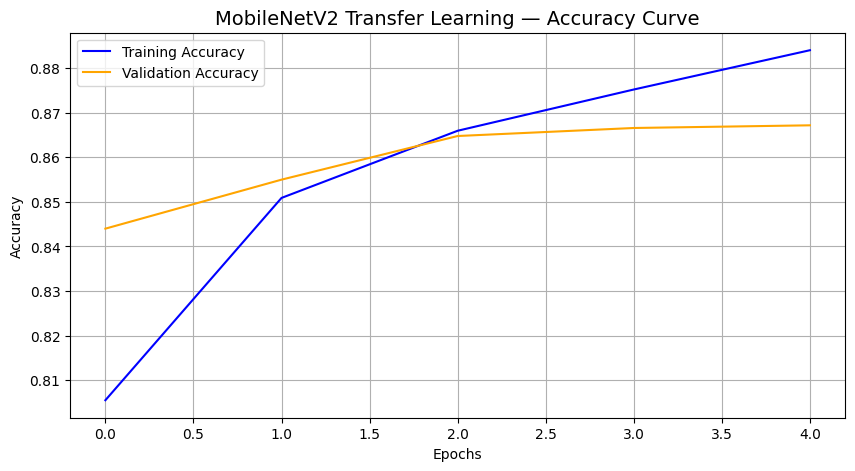

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('MobileNetV2 Transfer Learning — Accuracy Curve', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()